In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


In [2]:
# Load data
tsla_data = pd.read_csv("../data/cleaned_tsla_data.csv", parse_dates=['Date'], index_col='Date')

# Focus on 'Adj Close' for forecasting
tsla_data = tsla_data[['Adj Close']]

# Check for stationarity
result = adfuller(tsla_data['Adj Close'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.2077635687688493
p-value: 0.670247135774911


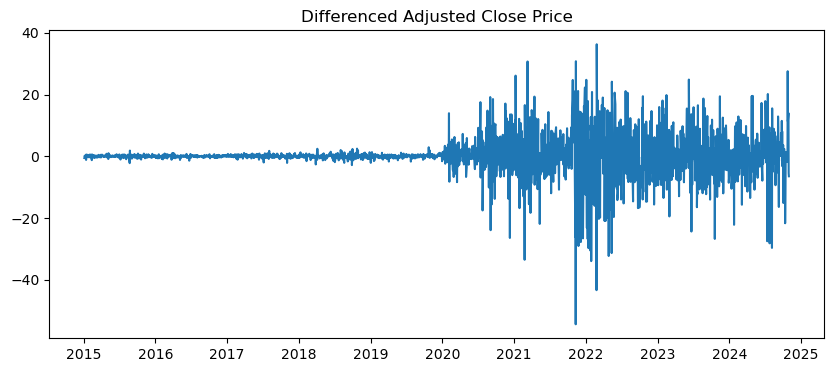

ADF Statistic after differencing: -9.908203309903513
p-value after differencing: 3.221043070336439e-17


In [3]:
# Differencing
tsla_data_diff = tsla_data['Adj Close'].diff().dropna()

# Plot to visualize differenced data
plt.figure(figsize=(10, 4))
plt.plot(tsla_data_diff)
plt.title('Differenced Adjusted Close Price')
plt.show()

# Check stationarity again
result = adfuller(tsla_data_diff)
print(f"ADF Statistic after differencing: {result[0]}")
print(f"p-value after differencing: {result[1]}")


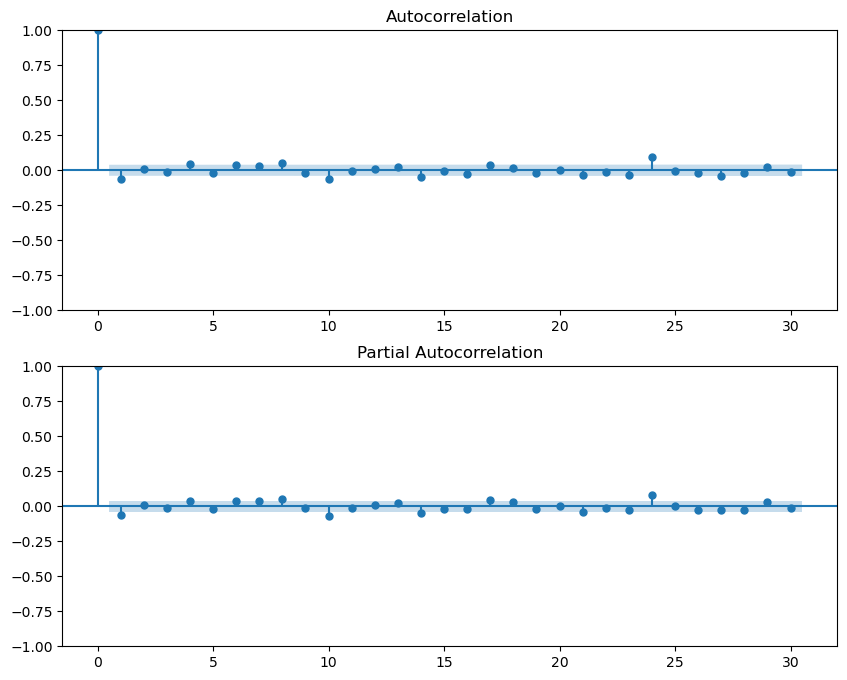

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(tsla_data_diff, ax=ax[0], lags=30)
plot_pacf(tsla_data_diff, ax=ax[1], lags=30)
plt.show()


In [6]:
# Define the ARIMA model
p, d, q = 1, 1, 1  # Adjust based on ACF/PACF
model = ARIMA(tsla_data['Adj Close'], order=(p, d, q))
arima_model = model.fit()

# Summary of the model
print(arima_model.summary())


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 2474
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -8016.084
Date:                Sat, 09 Nov 2024   AIC                          16038.168
Time:                        02:40:34   BIC                          16055.607
Sample:                             0   HQIC                         16044.502
                               - 2474                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7392      0.083     -8.917      0.000      -0.902      -0.577
ma.L1          0.6937      0.088      7.922      0.000       0.522       0.865
sigma2        38.2832      0.473     80.923      0.0

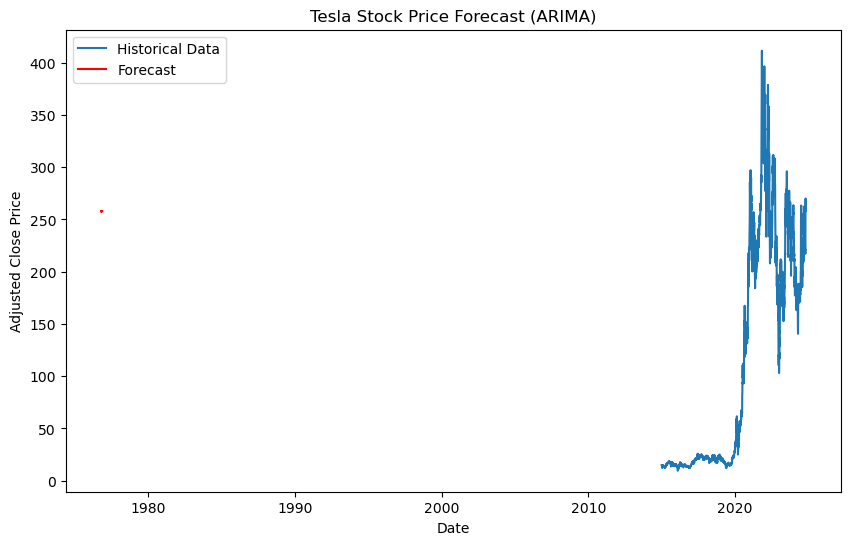

In [7]:
# Forecasting next 30 days
forecast_steps = 30
forecast = arima_model.forecast(steps=forecast_steps)

# Plotting the forecast
plt.figure(figsize=(10, 6))
plt.plot(tsla_data['Adj Close'], label='Historical Data')
plt.plot(forecast.index, forecast, color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.title('Tesla Stock Price Forecast (ARIMA)')
plt.show()


In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compare forecast with actual data (use last 'forecast_steps' points)
actual = tsla_data['Adj Close'][-forecast_steps:]
mae = mean_absolute_error(actual, forecast)
mse = mean_squared_error(actual, forecast)
mape = np.mean(np.abs((actual - forecast) / actual)) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")


Mean Absolute Error (MAE): 17.973474732270756
Mean Squared Error (MSE): 526.1090855866865
Mean Absolute Percentage Error (MAPE): nan%


In [11]:
from pmdarima import auto_arima

# Automated ARIMA model
auto_model = auto_arima(tsla_data['Adj Close'], seasonal=False, trace=True)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=16042.026, Time=2.27 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16046.765, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=16039.499, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=16039.627, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16045.387, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=16041.412, Time=0.19 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=16039.510, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=16040.445, Time=1.27 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=16038.204, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=16040.108, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=16038.168, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=16038.337, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=16039.130, Time=0.59 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=16039.053, Time=0.34 sec
 ARIMA(0,1,2)(0,0,0

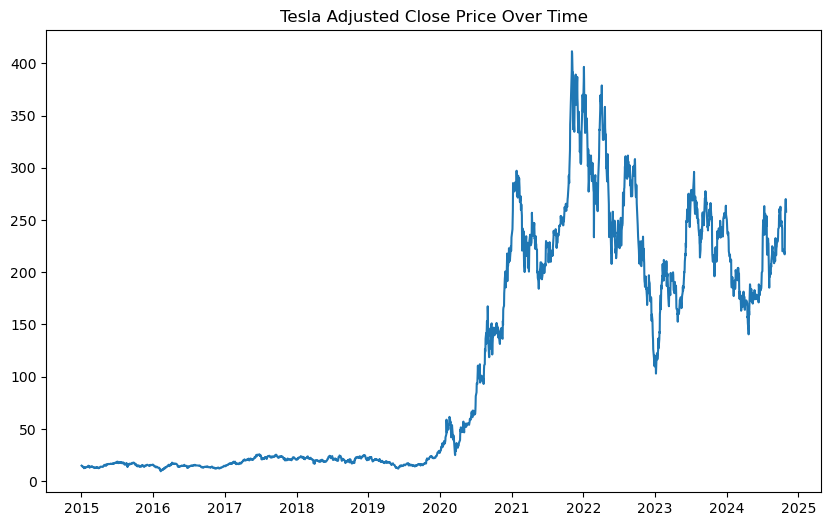

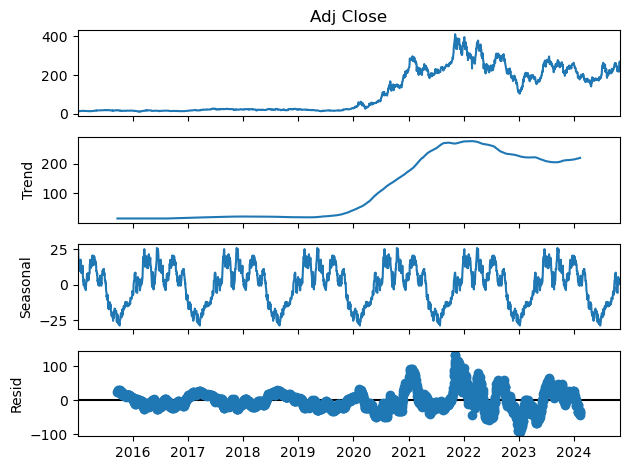

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Load data
tsla_data = pd.read_csv("../data/cleaned_tsla_data.csv", parse_dates=['Date'], index_col='Date')
tsla_data = tsla_data[['Adj Close']]

# Visualize data
plt.figure(figsize=(10, 6))
plt.plot(tsla_data)
plt.title("Tesla Adjusted Close Price Over Time")
plt.show()

# Seasonal decomposition
decomposition = seasonal_decompose(tsla_data['Adj Close'], model='additive', period=365)
decomposition.plot()
plt.show()


In [16]:
from statsmodels.tsa.stattools import adfuller

# ADF test for stationarity
result = adfuller(tsla_data['Adj Close'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -1.2077635687688493
p-value: 0.670247135774911
